In [5]:
import sklearn.metrics
import numpy as np
import pandas as pd
from transparentai.datasets import load_adult, load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from transparentai.models import classification

import transparentai.fairness as fairness

In [6]:
data = load_adult()
X, Y = data.drop(columns='income'), data['income']
X = X.select_dtypes('number')
Y = Y.replace({'>50K':1, '<=50K':0})
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)
clf = RandomForestClassifier()
clf.fit(X_train,Y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [7]:
y_true = Y_train
y_true_valid = Y_valid
y_pred = clf.predict_proba(X_train)
y_pred_valid = clf.predict_proba(X_valid)

In [8]:
privileged_group = {
    'gender':['Male'],                
    'age': lambda x: x > 30 & x < 55, 
    'workclass': ['Private'],
    'marital-status': lambda x: 'Married' in x,
    'race':['White'],
    'test':['d']
}

df_valid = data.loc[X_valid.index,:]
df_train = data.loc[X_train.index,:]

res_train = fairness.compute_fairness_metrics(y_true, 
                                     y_pred, 
                                     df_train,
                                     privileged_group)

res_valid = fairness.compute_fairness_metrics(y_true_valid, 
                                     y_pred_valid, 
                                     df_valid,
                                     privileged_group)

/usr/local/lib/python3.7/site-packages/transparentai-0.2.0-py3.7.egg/transparentai/fairness/fairness.py:60: UserWarning: test variable is not in df columns
  warnings.warn('%s variable is not in df columns' % k)


In [5]:
print(res_train)
print()
print(res_valid)

{'gender': {'statistical_parity_difference': -0.19476541000793168, 'disparate_impact': 0.36193507464018176, 'equal_opportunity_difference': 0.0012555131216205329, 'average_odds_difference': 0.0002648639770150698, 'theil_index': 0.0009858691255119644}, 'age': {'statistical_parity_difference': -0.203725061026309, 'disparate_impact': 0.25714521167788223, 'equal_opportunity_difference': -0.007162267576955039, 'average_odds_difference': -0.0037346275592520773, 'theil_index': 0.0009858691255119644}, 'workclass': {'statistical_parity_difference': 0.07348962811212864, 'disparate_impact': 1.3373409073344713, 'equal_opportunity_difference': 0.0018590852857182094, 'average_odds_difference': 0.0007175586065426077, 'theil_index': 0.0009858691255119644}, 'marital-status': {'statistical_parity_difference': -0.3723357356482332, 'disparate_impact': 0.14530776576648555, 'equal_opportunity_difference': 0.001977948760519821, 'average_odds_difference': 0.0007141900360776936, 'theil_index': 0.00098586912551

In [6]:
from transparentai.datasets import load_boston
from sklearn.linear_model import LinearRegression

data = load_boston()
X, Y = data.drop(columns='MEDV'), data['MEDV']
X_train, X_valid, Y_train, Y_valid = train_test_split(X, Y, test_size=0.33, random_state=42)
regr = LinearRegression()
regr.fit(X_train, Y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [7]:
y_true = Y_train
y_true_valid = Y_valid
y_pred = regr.predict(X_train)
y_pred_valid = regr.predict(X_valid)

In [8]:
privileged_group = {
    'AGE': lambda x: (x > 30) & (x < 55)
}

df_valid = data.loc[X_valid.index,:]
df_train = data.loc[X_train.index,:]

res_train = fairness.compute_fairness_metrics(y_true, y_pred, df_train,
                                              privileged_group, regr_split='mean')

res_valid = fairness.compute_fairness_metrics(y_true_valid, y_pred_valid, 
                                              df_valid, privileged_group, regr_split='mean')

In [9]:
print(res_train)
print()
print(res_valid)

{'AGE': {'statistical_parity_difference': -0.24278409090909092, 'disparate_impact': 0.6386469344608879, 'equal_opportunity_difference': 0.030268418046830448, 'average_odds_difference': -0.13176501578278632, 'theil_index': 0.07290000413883886}}

{'AGE': {'statistical_parity_difference': -0.32598939208486327, 'disparate_impact': 0.5575858250276855, 'equal_opportunity_difference': 0.05590062111801242, 'average_odds_difference': -0.19990227625885348, 'theil_index': 0.08033756338030891}}


In [10]:
from transparentai.fairness import metrics
metrics.statistical_parity_difference
metrics.equal_opportunity_difference
metrics.average_odds_difference
metrics.disparate_impact
metrics.theil_index

# from transparentai.fairness import model_bias

# model_bias(y_true, y_pred, social_attr, returns_text=False)

<function transparentai.fairness.metrics.theil_index(y_true, y_pred, prot_attr, pos_label=1)>

In [12]:
fairness.

{'statistical_parity_difference': <function transparentai.fairness.metrics.statistical_parity_difference(y, prot_attr, pos_label=1)>,
 'disparate_impact': <function transparentai.fairness.metrics.disparate_impact(y, prot_attr, pos_label=1)>,
 'equal_opportunity_difference': <function transparentai.fairness.metrics.equal_opportunity_difference(y_true, y_pred, prot_attr, pos_label=1)>,
 'average_odds_difference': <function transparentai.fairness.metrics.average_odds_difference(y_true, y_pred, prot_attr, pos_label=1)>,
 'theil_index': <function transparentai.fairness.metrics.theil_index(y_true, y_pred, prot_attr, pos_label=1)>}

In [95]:
def fairness_metrics_goal_threshold(metric):
    """
    """
    metrics_goal_1 = [
        'disparate_impact'
    ]
    
    if metric in metrics_goal_1:
        return 1, 0.2
    elif metric == 'theil_index':
        return 0, 0.2
    return 0, 0.1

def is_metric_fair(score, metric):
    """
    """
    goal, threshold = fairness_metrics_goal_threshold(metric)
    return np.abs(score - goal) <= threshold 
    
    
def fairness_metrics_text(score, metric):
    """
    """
    score = round(score, 4)
      
    if metric == 'statistical_parity_difference':
        g1, g2 = ('un', '') if (score) > 0 else ('', 'un')  
        
        return 'The %sprivileged group is predicted '%g1 + '\
with the positive output %.2f%% more often than the %sprivileged group.'%(abs(score)*100, g2)
    
    elif metric == 'disparate_impact':
        g1, g2 = ('un', '') if (score) > 1 else ('', 'un')  
        score  = np.reciprocal(score) if score < 1 else score
        
        return 'The %sprivileged group is predicted '%g1 + '\
with the positive output %.2f times more often than the %sprivileged group.'%(score, g2)
    
    elif metric == 'equal_opportunity_difference':
        g1, g2 = ('un', '') if (score) > 0 else ('', 'un')  
        
        return 'For a person in the %sprivileged group, '%g1 + '\
the model predict a correct positive output %.2f%% more often than a person in the %sprivileged group.'%(abs(score)*100, g2)
    
    elif metric == 'average_odds_difference':
        g1, g2 = ('un', '') if (score) > 0 else ('', 'un')  
        
        return 'For a person in the %sprivileged group, '%g1 + '\
the model predict a correct positive output or a correct negative output %.2f%% more often '%(abs(score)*100) + '\
than a person in the %sprivileged group.'%(g2)
    
    return ''

    
def model_bias(y_true, y_pred, df, privileged_group, 
               pos_label=1, regr_split=None, returns_text=False):
    """Computes the fairness metrics for protected attributes
    refered in the privileged_group argument.
    
    It uses the 4 fairness function :

    - statistical_parity_difference
    - disparate_impact
    - equal_opportunity_difference
    - average_odds_difference

    You can also use it for a regression problem. You can set a value
    in the regr_split argument so it converts it to a binary classification problem.
    To use the mean use 'mean'.
    If the favorable label is more than the split value 
    set pos_label argument to 1 else to 0.

    This function is using the fairness.compute_metrics function.
    So if returns_text is False then it's the same output.
    
    Example :
    >>> from transparentai.datasets import load_boston
    >>> from sklearn.linear_model import LinearRegression

    >>> data = load_boston()
    >>> X, y = data.drop(columns='MEDV'), data['MEDV']
    >>> regr = LinearRegression().fit(X, y)

    >>> privileged_group = {
        'AGE': lambda x: (x > 30) & (x < 55)
    }
    >>> y_true, y_pred = y, regr.predict(X)
    >>> model_bias(y_true, y_pred, data, 
                   privileged_group, regr_split='mean')
    {'AGE': {'statistical_parity_difference': -0.2041836536594836,
      'disparate_impact': 0.674582301980198,
      'equal_opportunity_difference': 0.018181818181818188,
      'average_odds_difference': -0.0884835589941973,
      'theil_index': 0.06976073748626294}}
    

    Parameters
    ----------
    y_true: array like
        True labels
    y_pred: array like
        Predicted labels
    df: pd.DataFrame
        Dataframe to extract privilieged group from.
    privileged_group: dict
        Dictionnary with protected attribute as key (e.g. age or gender)
        and a list of favorable value (like ['Male']) or a function
        returning a boolean corresponding to a privileged group
    pos_label: number
        The label of the positive class.
    regr_split: 'mean' or number (default None)
        If it's a regression problem then you can convert result to a
        binary classification using 'mean' or a choosen number.
        both y_true and y_pred become 0 and 1 : 0 if it's equal or less
        than the split value (the average if 'mean') and 1 if more.
        If the favorable label is more than the split value set pos_label=1
        else pos_label=0
    returns_text: bool (default False)
        Whether it return computed metrics score or a text explaination
        for the computed bias.
    Returns
    -------
    dict:
        Dictionnary with metric's name as key and 
        metric function's result as value if returns_text is False
        else it returns a text explaining the model fairness over
        the 4 metrics.
    """
    metrics = ['statistical_parity_difference',
               'disparate_impact',
               'equal_opportunity_difference',
               'average_odds_difference']
    
    scores = fairness.compute_fairness_metrics(y_true, y_pred, df, privileged_group, 
                                               metrics, pos_label, regr_split='mean')
    
    if not returns_text:
        return scores
    
    res = {}
    for attr, bias_scores in scores.items():
        txt = list()
        n_fair = 0
        for metric, score in bias_scores.items():
            is_fair = is_metric_fair(score, metric)
            fair_text = '' if is_fair else ' not'
            fair_text = ' This is considered to be%s fair.'%(fair_text)
            
            txt.append(fairness_metrics_text(score, metric) + fair_text)
            
            if is_fair: n_fair+=1
                
        txt.append('The model has %i fair metrics over 4 (%i%%).'%(n_fair, n_fair*100/4))
        res[attr] = "\n".join(txt)
    
    return res
    

In [277]:
import textwrap
print("\n".join(textwrap.wrap('qsdqsdqsdqsdqsdqsdqsdqsdqsdqsdqsdqsd', width=5)))

qsdqs
dqsdq
sdqsd
qsdqs
dqsdq
sdqsd
qsdqs
d


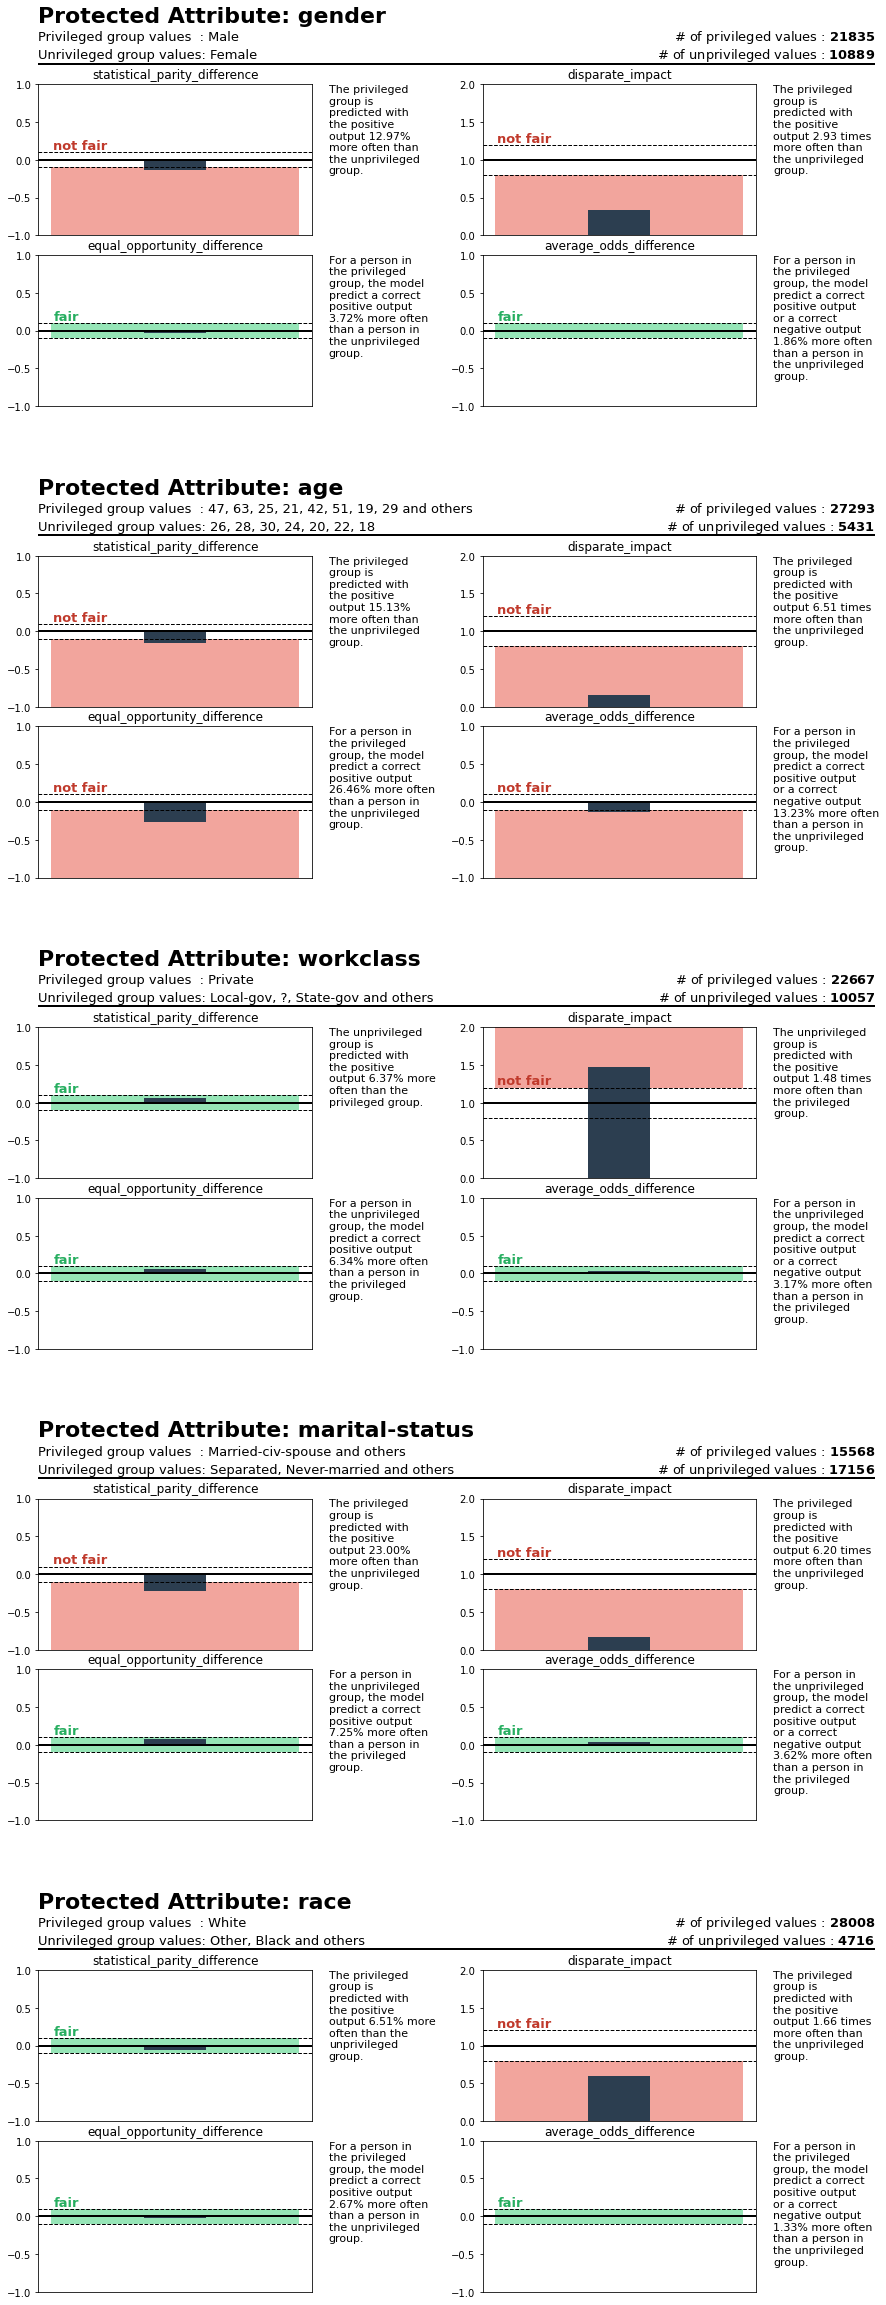

In [290]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import textwrap


def get_protected_attr_values(attr, df, privileged_group, privileged=True):
    """
    """
    val = privileged_group[attr]
    if type(val) == list:
        if privileged:
            return val
        fn = lambda x: x in val
    else:
        fn = val
    
    cond = df[attr].apply(fn) == privileged
    return df[cond][attr].unique().astype(str).tolist()
    
    
    
def format_priv_text(values, max_char):
    """
    """
    priv_text = ''
    
    for val in values:
        if (len(val) + len(priv_text) > max_char) & (priv_text != ''):
            priv_text = priv_text[:-2] + ' and others  '
            break
        priv_text += val+', '   
        
    return priv_text[:-2]

def plot_attr_title(ax, attr, df, privileged_group):
    """
    """
    if attr not in df.columns:
        raise ValueError('attr must be in df columns')
    if attr not in privileged_group:
        raise ValueError('attr must be in privileged_group keys')
    
    plt.text(0,1.4,'Protected Attribute: %s'%attr, fontsize=22, weight="bold")
    priv_df = fairness.create_privilieged_df(df, privileged_group)[attr]
    
    priv_values   = get_protected_attr_values(attr, df, privileged_group)
    unpriv_values = get_protected_attr_values(attr, df, privileged_group, privileged=False)
    
    priv_text     = format_priv_text(priv_values, max_char=30)
    unpriv_text   = format_priv_text(unpriv_values, max_char=30)
    
    n_priv        = (priv_df == 1).sum()
    n_unpriv      = (priv_df == 0).sum()
    
    plt.text(0,0.8,'Privileged group values  : %s'%(priv_text), fontsize=13)
    plt.text(0,0.2,'Unrivileged group values: %s'%(unpriv_text), fontsize=13)
    
    plt.text(1,0.8,r'# of privileged values : $\bf{%i}$'%(n_priv), 
             fontsize=13, horizontalalignment='right')
    plt.text(1,0.2,r'# of unprivileged values : $\bf{%i}$'%(n_unpriv), 
             fontsize=13, horizontalalignment='right')
    
    
    plt.axis('off')
    ax.axhline(0, color='#000', linewidth=5)

def plot_bias_one_attr(ax, metric, score):
    """
    """
    goal, threshold = fairness_metrics_goal_threshold(metric)
    is_fair = is_metric_fair(score, metric)

    ax.set_ylim((goal-1, goal+1))
    ax.axhline(goal, color='#000', linewidth=2)
    ax.axhline(goal-threshold, color='#000', linewidth=1, linestyle='--')
    ax.axhline(goal+threshold, color='#000', linewidth=1, linestyle='--')

    ax.bar(0.5, score, color='#2c3e50', width=0.25, zorder=2)

    y        = goal-threshold if is_fair else goal-1 if score < goal else goal+threshold
    h        = 2*threshold    if is_fair else 1-threshold
    bg_color ='#2ecc71'       if is_fair else '#e74c3c'
    text     = 'fair'         if is_fair else 'not fair'
    color    = '#27ae60'      if is_fair else '#c0392b'        

    ax.text(0.01, goal+threshold+0.04, text, fontsize=13,
                color=color,weight="bold")

    rect = Rectangle((0,y), 1, h, facecolor=bg_color, 
                     alpha=0.5, zorder=1)
    ax.add_patch(rect)

    ax.get_xaxis().set_ticks([])
    ax.set_title(metric)    
    
def plot_fairness_text(ax, score, metric):
    """
    """
    text = fairness_metrics_text(score, metric)
    
    text = "\n".join(textwrap.wrap(text, width=17))
    
    ax.text(-0.5, 1, text, ha='left', fontsize=11,
         va='top', wrap=True)
    
    
    
    for sp in ['top','right','left','bottom']:
        ax.spines[sp].set_visible(False)
    ax.set_yticks([])
    ax.set_xticks([])
    

def plot_bias(y_true, y_pred, df, privileged_group, pos_label=1, 
              regr_split=None, with_text=True):
    """Plots the fairness metrics for protected attributes
    refered in the privileged_group argument.
    
    It uses the 4 fairness function :

    - statistical_parity_difference
    - disparate_impact
    - equal_opportunity_difference
    - average_odds_difference

    You can also use it for a regression problem. You can set a value
    in the regr_split argument so it converts it to a binary classification problem.
    To use the mean use 'mean'.
    If the favorable label is more than the split value 
    set pos_label argument to 1 else to 0.

    Parameters
    ----------
    y_true: array like
        True labels
    y_pred: array like
        Predicted labels
    df: pd.DataFrame
        Dataframe to extract privilieged group from.
    privileged_group: dict
        Dictionnary with protected attribute as key (e.g. age or gender)
        and a list of favorable value (like ['Male']) or a function
        returning a boolean corresponding to a privileged group
    pos_label: number
        The label of the positive class.
    regr_split: 'mean' or number (default None)
        If it's a regression problem then you can convert result to a
        binary classification using 'mean' or a choosen number.
        both y_true and y_pred become 0 and 1 : 0 if it's equal or less
        than the split value (the average if 'mean') and 1 if more.
        If the favorable label is more than the split value set pos_label=1
        else pos_label=0
    """
    metrics = ['statistical_parity_difference',
               'disparate_impact',
               'equal_opportunity_difference',
               'average_odds_difference']
    
    scores = fairness.compute_fairness_metrics(y_true, y_pred, df, privileged_group, 
                                               metrics, pos_label, regr_split='mean')
    
    n_attr = len(scores)
    
    if not with_text:
        widths = [1]*4
        heights = [1,5,2]*n_attr
    else:
        widths = [4,1]*2
        heights = [1,5,5,2]*n_attr
        
        
    fig = plt.figure(figsize=(15, 7*n_attr + (int(with_text)*8)))
    
    gs = fig.add_gridspec(len(heights), 4, 
                          wspace=0.3,
                          width_ratios=widths,
                          height_ratios=heights)

    row = 0
    for attr, bias_scores in scores.items():
        ax   = fig.add_subplot(gs[row, :])
        plot_attr_title(ax, attr, df, privileged_group)
        
        axes = [fig.add_subplot(gs[row+1+j, i]) 
                for j in range(int(with_text)+1) 
                for i in range(4)]
        
        for i, (metric, score) in enumerate(bias_scores.items()):
            ax = axes[i] if not with_text else axes[i*2]
            plot_bias_one_attr(ax, metric, score)
            
            if not with_text:
                continue
            
            ax = axes[i*2+1]
            plot_fairness_text(ax, score, metric)
                
        

        # Separator line
        ax   = fig.add_subplot(gs[row+2, :])
        plt.axis('off')
        
#         break
        row += 3+int(with_text)
        
    plt.show()
#     return fig
    
plot_bias(y_true, y_pred, df_train, privileged_group, with_text=True)

In [98]:

privileged_group = {
    'gender':['Male'],                
    'age': lambda x: x > 30 & x < 55, 
    'workclass': ['Private'],
    'marital-status': lambda x: 'Married' in x,
    'race':['White']
}
    
res_train = model_bias(y_true, y_pred, df_train, privileged_group, returns_text=True)

res_valid = model_bias(y_true_valid, y_pred_valid, 
                         df_valid, privileged_group, returns_text=True)


print(res_valid['age'])

The privileged group is predicted with the positive output 10.12% more often than the unprivileged group. This is considered to be not fair.
The privileged group is predicted with the positive output 8.42 times more often than the unprivileged group. This is considered to be not fair.
For a person in the privileged group, the model predict a correct positive output 17.30% more often than a person in the unprivileged group. This is considered to be not fair.
For a person in the privileged group, the model predict a correct positive output or a correct negative output 9.88% more often than a person in the unprivileged group. This is considered to be fair.
The model has 1 fair metrics over 4 (25%).
